In [2]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, TimeDistributed, Bidirectional
from keras.layers import LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import keras
import codecs
import os

%matplotlib inline

Using TensorFlow backend.


In [3]:
import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [4]:
!ls

datasetCSV.zip		 DetectedAuthorTwitter.ipynb  LICENSE
datasetHabrahabr.csv	 DetectedAuthorVK.ipynb       model
dataset.zip		 echo_posts_100_and_more.csv  posts.csv
DetectedAuthorRNN.ipynb  Habrahabr		      README.md


In [5]:
# Устанавливаем seed для повторяемости результатов
np.random.seed(42)

In [6]:
N = 10
with open("echo_posts_100_and_more.csv") as myfile:
    head = [next(myfile) for x in range(N)]
print(head)

['|Author|Text\n', '0|ААВ-старший|"\n', '\n', 'Я\xa0сожалею, что начало передачи с\xa0Леонидом Волковым было скомкано. \n', '\n', 'Приношу извинения тем слушателям Эха, которые сочли этот инцидент неуместным  \n', '\n', '«Эхо Москвы» готово предложить дебаты между Ксенией Собчак и\xa0Алексеем Навальным.  \n', 'Оригинал "\n', '1|ААВ-старший|"\n']


In [7]:
data = pd.read_csv('echo_posts_100_and_more.csv', sep='|', engine='python', index_col=0)
data.head()

,Author,Text
0,ААВ-старший,"\n\nЯ сожалею, что начало передачи с Леонидом ..."
1,ААВ-старший,"\n\nПонятно, почему Путин рассказывал о высоко..."
2,ААВ-старший,"\n\nСчитал и считаю, что отказ в регистрации А..."
3,ААВ-старший,\nО странностях жизни. \nПутин благодарит Тра...
4,ААВ-старший,\n\nВот интересно – начальник Службы безопасно...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87640 entries, 0 to 87436
Data columns (total 2 columns):
Author    87437 non-null object
Text      80168 non-null object
dtypes: object(2)
memory usage: 2.0+ MB


In [7]:
# data = pd.read_csv('posts.csv', names=['Author', 'Text'], sep=',', header=None)
# data.head()

In [94]:
#from nltk.corpus import stopwords
#stop = stopwords.words('russian')
#data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
#print('Stop words have been deleted')
#data['Text'].apply(lambda x: x.replace('\n', ' '));

### Подсчет количества слов в корпусе

In [9]:
data.Text = data.Text.apply(str);

In [10]:
data['CountWords'] = data['Text'].map(lambda x: len(x.split()))
print('Количество статей в корпусе:', len(data))

Количество статей в корпусе: 87640


### Удаление спам пользователей

In [96]:
spam_list = [301557842, 184330667, 191315693, 111604181, 212846761, 278053852, 281162155, 206300456, 306859957, 19006413, 275267400, 131629784, 276695686, 227968805, 65265920, 215657793, 212066696, 281866527, 172515637, 420657548, 259904924, 103086082, 36309849, 151622711, 304407589, 304407589, 234135027, 330779808, 135431520, 326927985, 22070189, 16497456, 22070189, 16497456, 120772826, 181255568, 24655736, 90966607, 102977537, 317336618, 189704404, 11663845, 57439210, 163452787, 38680483, 121144040, 211289578, 280155968, 198528079, 277512341, 33152119, 314327791, 229101154, 271546215, 4121239, 59729051, 288393060, 17620663, 296431137, 320666372, 153340241, 13309210, 333014765, 24595847, 152263680, 135815313, 27763994, 34902711, 200488318, 393710429, 400853612, 18091069, 232368999, 243123251, 159034443, 101820061, 334397479, 36372315, 18412482, 362494239, 98538332, 94983825, 171941220, 35386477, 179364423, 136668179, 57446172, 288223392, 321431512, 277994902, 190694040, 325021098, 129392296, 289027630, 216216545, 75884932, 208023062, 185965346, 2857932, 2574325, 154034429, 312715518, 286913827, 336049060, 163410643, 309938895, 372204020, 400615680, 235441786, 8391421, 136997064, 174934251, 173179778, 134275738, 93070783, 403039516, 326194938, 26960550, 18090797, 15931375, 64401851, 14665799, 223678239, 1963998, 252135842, 16352364, 386230491, 135103805, 335233013, 226605259, 94018354, 363143703, 278775919, 134780377,498638, 498638, 20403116, 824871, 22259914, 203601767, 386435681, 280519165, 225577927, 336493264, 203836012, 250362235, 135154139, 332671406, 296879545, 191398452, 48411613, 276175277, 77459397, 15155303, 6646818, 174692652, 25755928, 145799445, 210213078, 225680585, 167783297, 159347782, 154637631, 343704548, 276329737, 158954181, 7736592, 52430830, 54738353, 181641220, 249065698, 356566757, 12276180, 146475131, 38034256, 301152537, 181250759, 65169740, 229445819, 360098848, 204181735, 311981137, 9365217, 323032519, 144081373, 166471693, 219977388, 3252582, 92645976, 341675206, 394122042, 8469671, 293599275, 150564713, 315874927, 75299334, 395839270, 256327432, 8758868, 234523373, 234523373] 
print('Count of spam users:', len(spam_list))
lam = lambda row: row['Author'] not in spam_list
data = data[data.apply(lam, axis=1)]

Count of spam users: 201


In [11]:
author_count_news = data.Author.value_counts()
print('Количество авторов в корпусе:', len(author_count_news))
#print(author_count_news[:-8300: -1])
#author_count_news.plot(kind='bar', figsize=(15, 5), title="Number of author's articles");

Количество авторов в корпусе: 290


### Количество статей у каждого пользователя

In [12]:
# Попробовать изменить количество статей у автора, у каждого 10 постов, 50, 100

num_classes = 100
skip_person = 9
author_count_news_dubset = author_count_news[skip_person:skip_person+num_classes]

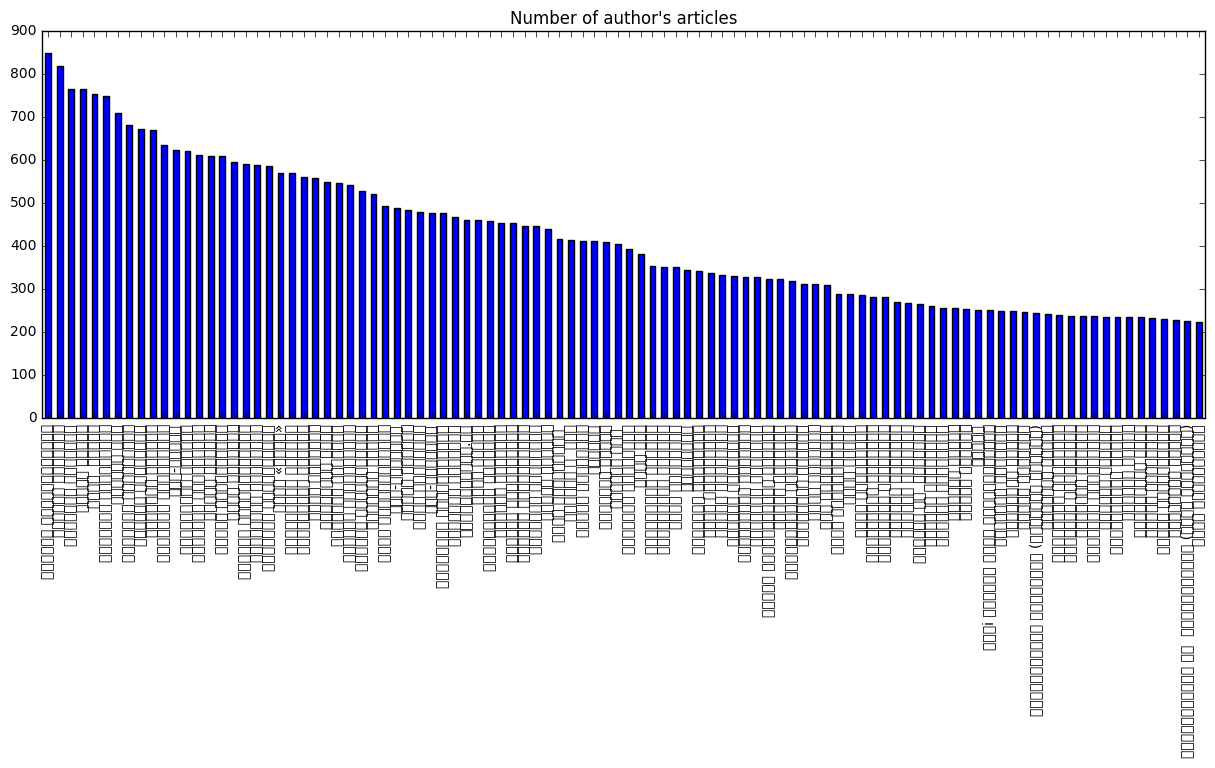

In [11]:
author_count_news_dubset.plot(kind='bar', figsize=(15, 5), title="Number of author's articles");

In [100]:
for i, (user_id, number) in enumerate(author_count_news.items()):
    print('User id', user_id)
    print(data[data.Author == user_id]['Text'][:2])
    print('===========')
    if i == 2:
        break

User id 2023105
2024    – Разве хегзы, это не те, кто взывает к легенд...
2025    — «Shoryuken» means «rising dragon fist», appa...
Name: Text, dtype: object
User id 225897827
70147    ✨✨ МОЙ МИР РАДУЕТ МЕНЯ СВОИМ ИЗОБИЛИЕМ И РАЗНО...
70148    "Мой новый взгляд на прощение или как я учусь ...
Name: Text, dtype: object
User id 82145315
32365    "... Полностью войдите в роль любителя, которы...
32366    "... Что бы мы ни говорили, что бы ни делали, ...
Name: Text, dtype: object


### Подготовка данных

In [13]:
temp_data = pd.DataFrame()
names_author = author_count_news_dubset.index.values

for author in names_author:
    temp_data = temp_data.append(data[data.Author == author])

data = temp_data
print('Количество статей после удаления:', len(data))

Количество статей после удаления: 41941


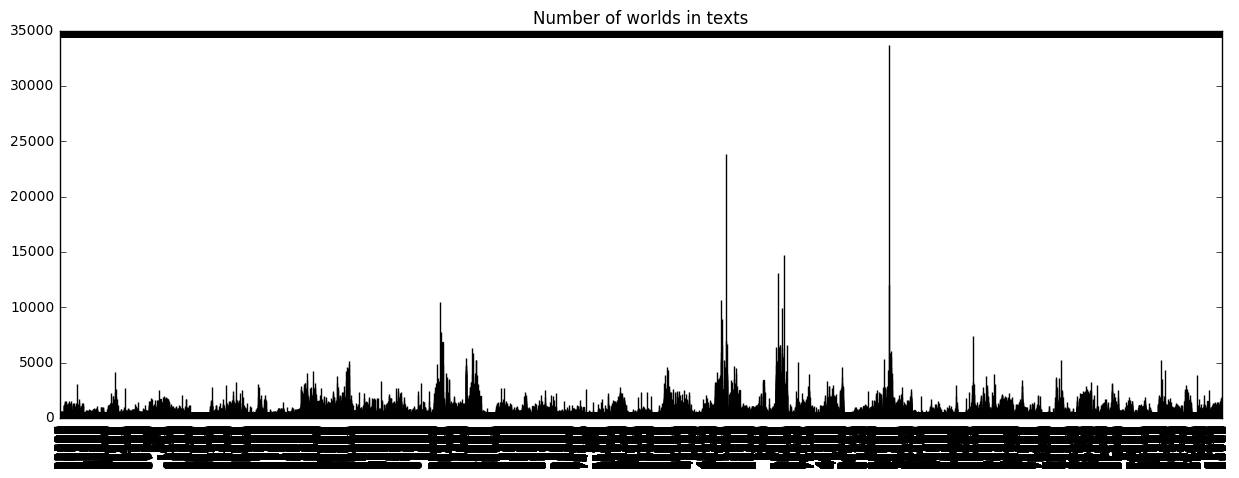

In [16]:
data.CountWords.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts");

In [102]:
# def remove_stopwords(data):
#     from nltk.corpus import stopwords
#     stop = stopwords.words('russian')
#     data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
#     print('Stop words have been deleted')

In [103]:
# def get_lemmatization_corpus(data):
#     import pymorphy2
#     morph = pymorphy2.MorphAnalyzer()
#     data['TextLem'] = data['Text'].map(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))
#     print('The lemmatization completed')

In [14]:
names = data.Author.value_counts().index.values

lableEnc = LabelEncoder()
lableEnc.fit(names.ravel()) 
lables = lableEnc.transform(names).reshape((num_classes, 1))

oneHotEnc = OneHotEncoder()
oneHotEnc.fit(lables)

for author in names:
    val = lableEnc.transform([author])[0]
    data.Author.replace(to_replace=author, value=val, inplace=True)

data.head()

,Author,Text,CountWords
22596,67,\n\nРоссия предложила вернуть Украине военные ...,334
22597,67,\n\nРоссийские властные комики продолжают жечь...,457
22598,67,\n\nЕсть такое украинское слово «чорноротый». ...,384
22599,67,\n\nПесков отказался назвать имя того самого у...,455
22600,67,"\nТут для начала хочу напомнить, что в Америке...",481


In [15]:
# Перемешать набор данных и удалить index столбец
data = data.sample(frac=1).reset_index(drop=True)

### Токенизация текста

In [16]:
def get_texts_to_matrix(texts, max_features = 0):
    tokenizer = Tokenizer(split=" ", lower=True)
    if max_features != 0:
        tokenizer = Tokenizer(split=" ", lower=True, num_words=max_features)
    
    tokenizer.fit_on_texts(texts)
    matrix_tfidf = tokenizer.texts_to_matrix(texts=texts, mode='tfidf')
    print('Количество текстов:', matrix_tfidf.shape[0])
    print('Количество токенов:', matrix_tfidf.shape[1])
    return matrix_tfidf

In [17]:
# Убрать LowerCase

def get_texts_to_sequences(text):
    # создаем единый словарь (слово -> число) для преобразования
    tokenizer = Tokenizer(split=" ", lower=True)
    tokenizer.fit_on_texts(text)
    # Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
    text_sequences = tokenizer.texts_to_sequences(text)
    print('В словаре {} слов'.format(len(tokenizer.word_index)))
    return text_sequences

In [18]:
def get_texts_to_gramm_sequences(texts, count_gramm = 3):
    gramms = {}
    gram_id = 0
    result = []
    for text in texts:
        temp_vector = []
        count_grams_for_text = range(len(text) - count_gramm - 1)
        for i in count_grams_for_text:
            gramm = text[i : i + count_gramm]
            if gramm not in gramms:
                gramms[gramm] = gram_id
                gram_id += 1
            temp_vector.append(gramms[gramm])
        result.append(temp_vector)
    print('Количество грамм в корпусе:', len(gramms))
    return result

In [19]:
#X = get_texts_to_matrix(data['Text'], 80000)
#X = get_texts_to_gramm_sequences(data['Text'])
#X = get_texts_to_sequences(data['Text'])

In [20]:
X_gram_3 = get_texts_to_gramm_sequences(data['Text'], count_gramm = 3)
X_gram_4 = get_texts_to_gramm_sequences(data['Text'], count_gramm = 4)
X_seq = get_texts_to_sequences(data['Text'])

Количество грамм в корпусе: 184329
Количество грамм в корпусе: 937693
В словаре 1354211 слов


In [21]:
array_X = [X_gram_3, X_gram_4, X_seq]

In [22]:
def print_plot_mean(x):
    means = [len(x) for x in x]
    plt.plot(means);

In [55]:
len(X_gram_3[0])
#print_plot_mean(X_gram_3)
#print_plot_mean(X_gram_4)
#print_plot_mean(X_seq)

1747

In [24]:
X = X_gram_3

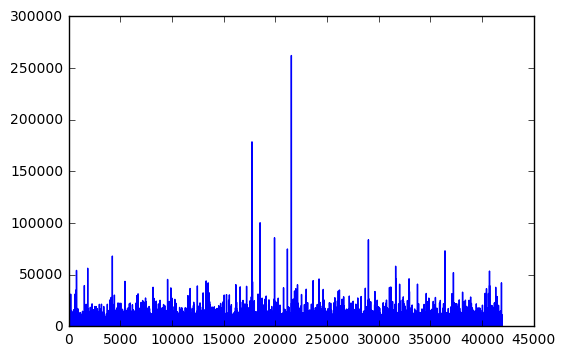

In [25]:
#plt.plot(X)
means = [len(x) for x in X]
plt.plot(means);
#X.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts");

### Разбиваем выборку на тестовую и тренировочную

In [23]:
def get_X_y_for_traning(X, y, num_words):
    #tokenizer = Tokenizer(num_words=num_words)
    #X = tokenizer.sequences_to_matrix(X, mode='binary')

    X = keras.preprocessing.sequence.pad_sequences(X, maxlen=num_words)     
    y = keras.utils.to_categorical(y, num_classes)
    print('Размерность X:', X.shape)
    print('Размерность y:', y.shape)
    return X, y

In [24]:
# Максимальное количество слов в самом длинном тексте
num_words = 20000
# X_full, y_full = get_X_y_for_traning(X_gram_3, data.Author, num_words)
# X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
array_sets = []
X_full, y_full = get_X_y_for_traning(X_gram_3, data.Author, num_words)
array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

X_full, y_full = get_X_y_for_traning(X_gram_4, data.Author, num_words)
array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

num_words = 2500
X_full, y_full = get_X_y_for_traning(X_seq, data.Author, num_words)
array_sets.append(train_test_split(X_full, y_full, test_size=0.2, random_state=42))

#print('Testing set size:', len(X_test))
#print('Training set size:', len(X_train))

Размерность X: (41941, 20000)
Размерность y: (41941, 100)
Размерность X: (41941, 20000)
Размерность y: (41941, 100)
Размерность X: (41941, 2500)
Размерность y: (41941, 100)


### Accuracy в зависимости от параметров Dropout
![alt text](https://2.downloader.disk.yandex.ru/preview/8e14c7756af3174dd350c25f3e6b8440a61e9a777ee2da314fd9f7fdd3091b2f/inf/rO8FnfsfSlEfAA1AjPLcJ2uQGpv-ZqVMnu5RumfWpo4yKYIGlxh3eJRayw6TcMCHwESHEemqBkkmTZnnheB-xQ%3D%3D?uid=0&filename=2018-02-04_19-53-32.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&tknv=v2&size=XXL&crop=0 "Logo Title Text 1")

### Accuracy в зависимости от Learning Rate
![alt text](https://2.downloader.disk.yandex.ru/preview/fa7057505b329e83b102d9815718569bd8495582c48d5fbe83bc35b0615263ce/inf/rO8FnfsfSlEfAA1AjPLcJ3LSAMr9nlqY5MHCpTZ2V9rMkRavocK8rFQ9rEwG9gspdkhMcLPBICDpAd1YRkHHlw%3D%3D?uid=0&filename=2018-02-04_19-54-48.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&tknv=v2&size=XXL&crop=0 "Logo Title Text 1")

### Accuracy в зависимости от Batch size
![alt text](https://4.downloader.disk.yandex.ru/disk/8eb281727507e6d15620d94175cec3ed4f509b3c40e5a820a1044c1e989e2dda/5a775771/rO8FnfsfSlEfAA1AjPLcJ6926tWJn_ypr-A-mql52eNcQXSffjilIJqUiUafRUZuc-1sR5I9yDwgiCUs2xFu6g%3D%3D?uid=0&filename=2018-02-04_19-56-28.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&fsize=29996&hid=308d82806a74c28ee7ee9c1432dbc6ba&media_type=image&tknv=v2&etag=849c2457f9719ab80079d07e58f899d9 "Logo Title Text 1")


### Создание модели нейронной сети

In [54]:
def get_lstm_model(input_length):
    model = Sequential()
    model.add(Embedding(input_length, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
def get_bidirectional_lstm():
    model = Sequential()
    model.add(Embedding(80000, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(10, dropout=0.3, recurrent_dropout=0.3)))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
def get_conv_conv_model():
    model = Sequential()
    model.add(Embedding(160000, 300))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
def get_conv_lstm_model():
    model = Sequential()
    #model.add(Dense(102562, activation='relu', input_shape=(8664, 600)))
    model.add(Embedding(100000, 200))
    model.add(SpatialDropout1D(0.3))
    #model.add(TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu')))
    #model.add(TimeDistributed(GlobalMaxPooling1D()))
    #model.add(TimeDistributed(Flatten()))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D())
    #model.add(Flatten())
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
def get_lstm_conv_model():
    model = Sequential()
    model.add(Embedding(160000, 300))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)) 
    #model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='sigmoid'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
def get_conv_model(embeding_size):
    model = Sequential()
    model.add(Embedding(embeding_size, 200))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
hist_array = []
for i, (X_train, X_test, y_train, y_test) in enumerate(array_sets):
    if i == 0:
        model = get_conv_model(embeding_size=184715) # 53.1 6-epoch
    if i == 1:
        model = get_conv_model(embeding_size=939841) # 53.1 6-epoch
    if i == 2:
        model = get_conv_model(embeding_size=1359198) # 53.1 6-epoch
        
    model.summary()

    BATCH_SIZE = 32
    EPOCHS = 10
    VERBOSE = 2

    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS, verbose=VERBOSE,
                        validation_data=(X_test, y_test)
                        #validation_split=0.1, 
                        #callbacks=[EarlyStopping(monitor='val_loss')]
                       )
    #hist_array.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         36943000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
Total params: 37,302,012
Trainable params: 37,302,012
Non-trainable params: 0
_________________________________________________________________
Train on 33552 samples, validate on 8389 samples
Epoch 1/10
1394s - loss: 2.0198 - acc: 0.5232 - val_loss: 0.9570 - val_acc: 0.743

/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 187968200 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 33552 samples, validate on 8389 samples
Epoch 1/10
1510s - loss: 1.9629 - acc: 0.5391 - val_loss: 0.8844 - val_acc: 0.7689
Epoch 2/10
1505s - loss: 0.5566 - acc: 0.8520 - val_loss: 0.7658 - val_acc: 0.8010
Epoch 3/10
1633s - loss: 0.2215 - acc: 0.9437 - val_loss: 0.7011 - val_acc: 0.8208
Epoch 4/10
1504s - loss: 0.0746 - acc: 0.9835 - val_loss: 0.7417 - val_acc: 0.8211
Epoch 5/10
1506s - loss: 0.0355 - acc: 0.9919 - val_loss: 0.8241 - val_acc: 0.8132
Epoch 6/10
1754s - loss: 0.0647 - acc: 0.9819 - val_loss: 0.9470 - val_acc: 0.8102
Epoch 7/10
1753s - loss: 0.0508 - acc: 0.9863 - val_loss: 0.9786 - val_acc: 0.8130
Epoch 8/10
1753s - loss: 0.0436 - acc: 0.9874 - val_loss: 0.9729 - val_acc: 0.8154
Epoch 9/10
1753s - loss: 0.0423 - acc: 0.9885 - val_loss: 1.0471 - val_acc: 0.8186
Epoch 10/10
1753s - loss: 0.0553 - acc: 0.9856 - val_loss: 1.0498 - val_acc: 0.8217
_________________________________________________________________
Layer (type)                 Output Shape             

/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 271839600 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 33552 samples, validate on 8389 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[1359198,200]
	 [[Node: mul_63/y = UnsortedSegmentSum[T=DT_FLOAT, Tindices=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_2/embedding_3/Gather_grad/Reshape, gradients_2/embedding_3/Gather_grad/Reshape_1/_119, mul_63/strided_slice)]]

Caused by op 'mul_63/y', defined at:
  File "/anaconda/envs/py35/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-00d7156dab11>", line 19, in <module>
    validation_data=(X_test, y_test)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py", line 863, in fit
    initial_epoch=initial_epoch)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/training.py", line 1413, in fit
    self._make_train_function()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/training.py", line 937, in _make_train_function
    self.total_loss)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/optimizers.py", line 420, in get_updates
    m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 829, in binary_op_wrapper
    y = ops.convert_to_tensor(y, dtype=x.dtype.base_dtype, name="y")
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 676, in convert_to_tensor
    as_ref=False)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 741, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 96, in _IndexedSlicesToTensor
    value.values, value.indices, value.dense_shape[0], name=name)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2703, in unsorted_segment_sum
    num_segments=num_segments, name=name)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1359198,200]
	 [[Node: mul_63/y = UnsortedSegmentSum[T=DT_FLOAT, Tindices=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_2/embedding_3/Gather_grad/Reshape, gradients_2/embedding_3/Gather_grad/Reshape_1/_119, mul_63/strided_slice)]]


In [26]:
X_train, X_test, y_train, y_test = array_sets[2]

model = get_conv_model(embeding_size=1359198) # 53.1 6-epoch

model.summary()

BATCH_SIZE = 8
EPOCHS = 10
VERBOSE = 2

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=VERBOSE,
                    validation_data=(X_test, y_test)
                    #validation_split=0.1, 
                    #callbacks=[EarlyStopping(monitor='val_loss')]
                   )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         271839600 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
Total params: 272,198,612
Trainable params: 272,198,612
Non-trainable params: 0
_________________________________________________________________


/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 271839600 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 33552 samples, validate on 8389 samples
Epoch 1/10
1313s - loss: 2.0779 - acc: 0.4987 - val_loss: 1.2015 - val_acc: 0.6852
Epoch 2/10
1298s - loss: 0.5818 - acc: 0.8517 - val_loss: 1.0358 - val_acc: 0.7355
Epoch 3/10
1294s - loss: 0.0694 - acc: 0.9855 - val_loss: 1.1773 - val_acc: 0.7192
Epoch 4/10
1289s - loss: 0.0301 - acc: 0.9926 - val_loss: 1.5661 - val_acc: 0.6690
Epoch 5/10
1289s - loss: 0.0271 - acc: 0.9927 - val_loss: 1.4401 - val_acc: 0.7010
Epoch 6/10
1291s - loss: 0.0208 - acc: 0.9940 - val_loss: 1.5282 - val_acc: 0.7052
Epoch 7/10
1289s - loss: 0.0199 - acc: 0.9948 - val_loss: 1.4818 - val_acc: 0.7196
Epoch 8/10
1292s - loss: 0.0159 - acc: 0.9958 - val_loss: 1.5540 - val_acc: 0.7190
Epoch 9/10
1293s - loss: 0.0218 - acc: 0.9941 - val_loss: 1.6801 - val_acc: 0.7101
Epoch 10/10
1275s - loss: 0.0082 - acc: 0.6891 - val_loss: 1.1921e-07 - val_acc: 0.0123


In [1]:
len(hist_array)

NameError: name 'hist_array' is not defined

In [ ]:
%%time
#model = get_lstm_model(120000) # 34.10 10-epoch
#model = get_bidirectional_lstm() # 50.86 20-epoch
model = get_conv_model() # 53.1 6-epoch
#model = get_conv_conv_model() # 54.04 7-epoch
#model = get_conv_lstm_model() # 53.17 10-epoch
#model = get_lstm_conv_model() # 52.60 10-epoch

model.summary()

BATCH_SIZE = 32
EPOCHS = 7
VERBOSE = 2

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=VERBOSE, 
                    validation_split=0.1, 
                    #callbacks=[EarlyStopping(monitor='val_loss')]
                   )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         30192200  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 200)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 512)         307712    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                25650     
Total params: 30,525,562
Trainable params: 30,525,562
Non-trainable params: 0
_________________________________________________________________
Train on 21942 samples, validate on 2438 samples
Epoch 1/7
880s - loss: 1.6866 - acc: 0.5625 - val_loss: 0.8000 - val_acc: 0.7834


In [59]:
print('Точность модели составляет: {}'.format(model.evaluate(X_test, y_test, batch_size=64, verbose=2)[1] * 100))

Точность модели составляет: 88.3182937009497


dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


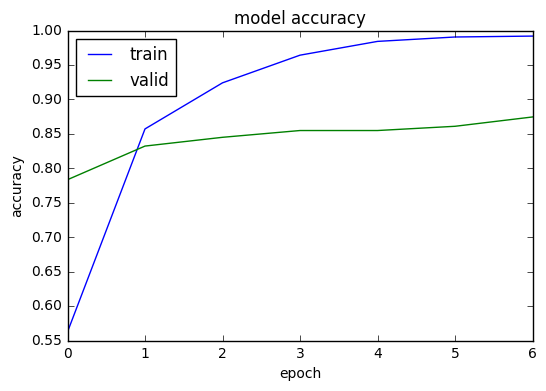

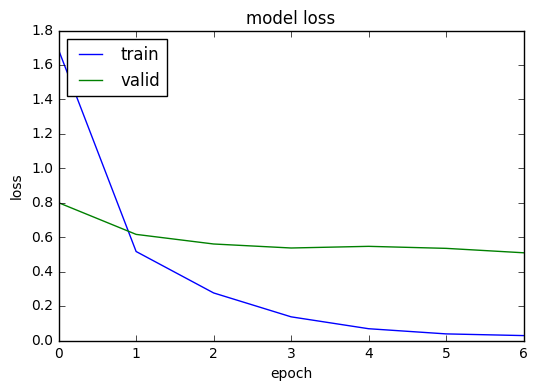

In [60]:
from matplotlib import pyplot as plt
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();

In [44]:
def save_model(model, model_name):
    # Генерируем описание модели в формате json
    model_json = model.to_json()
    # Записываем модель в файл
    json_file = open("model/{}_model.json".format(model_name), "w")
    json_file.write(model_json)
    json_file.close()
    model.save_weights("model/{}_weights.h5".format(model_name))
    print('Модель и веса успешно сохранены!')

In [58]:
save_model(model, 'vk_98percent_cnn')

Модель и веса успешно сохранены!
